# Data preprocessing

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from helpers import *
from datetime import datetime, timedelta, date
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list


demo = True
if demo:
    Countries_indexes = ["EWS"]
else:
    Countries_indexes = ["EUSA", "EWC", "EWU", "EWG", "EWQ", "EWJ", "MCHI", "INDA", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EWK", "EDEN", "EFNL", "EIS", "EWZ"]

If you don't have downloaded the .tar files skip to the EPPS effect

Here we import the raw data from the .tar files

In [ ]:
assets_data = get_raw_data(range(2009,2013), Countries_indexes)

Here we aggregate the times compute weighted average bid and ask, and then compute mid prices from these two as described in the report.

In [ ]:
bucketed_data = get_buckets(assets_data)

Here we remove the outliers from the data.

In [4]:
clean_data = remove_outliers(bucketed_data)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Example of pre and post outlier removal for EWS

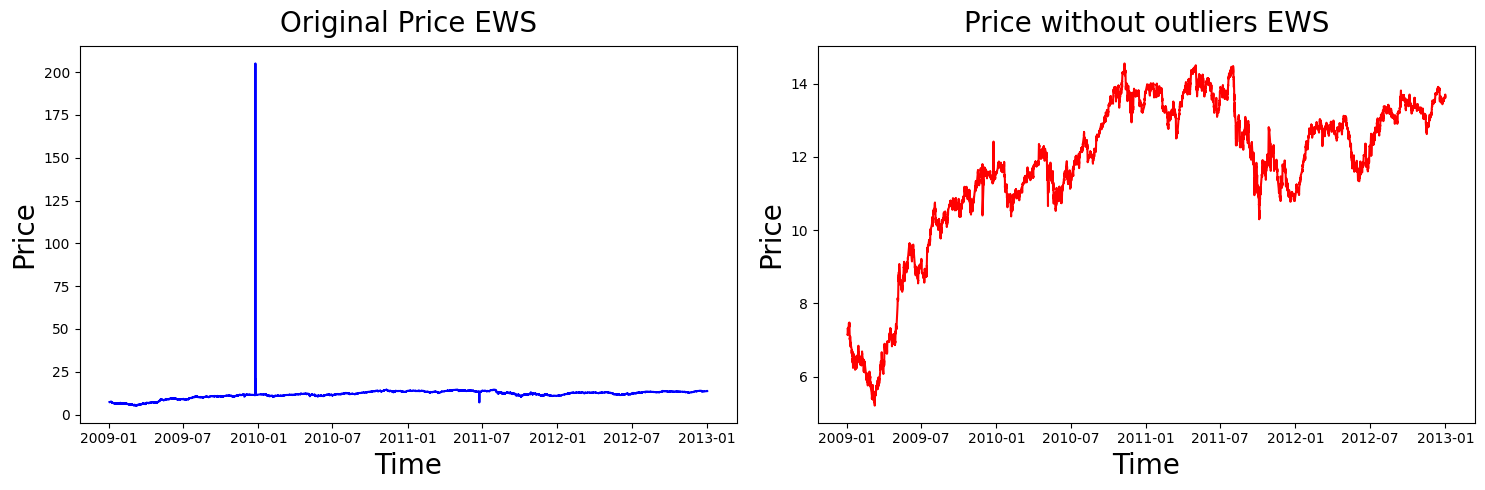

In [5]:
df, cleaned_df = bucketed_data["EWS"], clean_data["EWS"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original data
ax1.plot(df['time-bucket'], df['weighted-avg-price'], color='b')
ax1.set_title(f'Original Price EWS', va='bottom', fontdict={'fontsize': 20})
ax1.set_xlabel('Time', fontdict={'fontsize': 20})
ax1.set_ylabel('Price', fontdict={'fontsize': 20})

# Plot the cleaned data
ax2.plot(cleaned_df['time-bucket'], cleaned_df['weighted-avg-price'], color='r')
ax2.set_title(f'Price without outliers EWS', va='bottom', fontdict={'fontsize': 20})
ax2.set_xlabel('Time', fontdict={'fontsize': 20})
ax2.set_ylabel('Price', fontdict={'fontsize': 20})

plt.tight_layout()
plt.show()

Now we can save the clean data (if in demo, use the already processed data)

In [6]:
# save_folder = "Data/clean/"

# for key in clean_data.keys():
#     clean_data[key].write_parquet(f"{save_folder}{key}.parquet")

# Extreme mid-price jumps

In this section we see how there are some big outliers in the dataset due to the reasons decsribed in the report (low liquidity, price errors)

In [7]:
asset_data = get_raw_data(years = range(2007, 2013, 1) ,asset_names = ["EWO"], print_log=False)

Text(0.5, 1.0, 'EWO ask price')

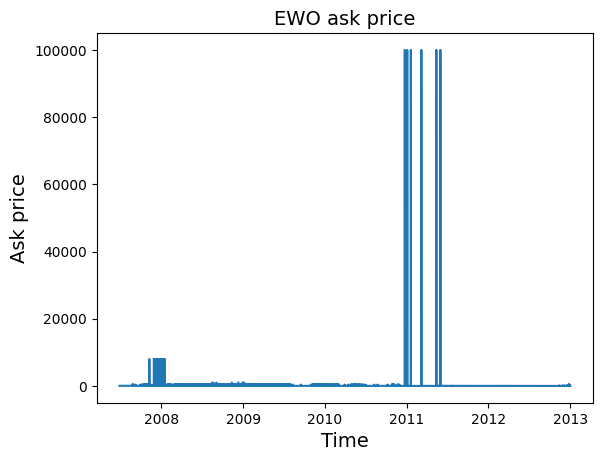

In [8]:
# plotting the ask price of EWO in time. We observe very extreme values in the ask price.
plt.plot(asset_data["EWO"]["datetime"],asset_data["EWO"]["ask-price"])
plt.xlabel("Time", fontdict={"size": 14})
plt.ylabel("Ask price", fontdict={"size": 14})
plt.title("EWO ask price", fontdict={"size": 14})

In [9]:
# Showing a sample of the jumps in the data
temp = asset_data["EWO"].filter(  
                                (pl.col("datetime").dt.date() == date(2007,8,24)) & (pl.col("datetime").dt.hour() == 13))
 
for row in temp.iter_rows(named=True):
    print(row)


{'bid-price': 36.76, 'bid-volume': 20, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 565000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 86, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 993000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 106, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 1, 392000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 6, 39999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.95, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 25, 307999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.77, 'bid-volume': 5, 'ask-price': 36.95, '

# Average Difference plot

This is how we get average difference of times between one observation and the previous one 

In [ ]:
average_diff_seconds = get_average_diffs(assets_data)

For the demo version we get the average difference of only one asset, don't save this and load the already computed one

In [11]:
### Save the average_diff_seconds to a csv file ##
# 
# 
#  data = []
# for ticker in Countries_indexes:
#     if ticker in average_diff_seconds:
#         seconds_val = average_diff_seconds[ticker].total_seconds()  
#         data.append((ticker, seconds_val))

# df = pd.DataFrame(data, columns=["Ticker", "Total_Seconds"])

# df.to_csv("Data/average_diffs_seconds.csv", index=False)

Load data

In [12]:
average_diff_seconds = pd.read_csv("Data/average_diffs_seconds.csv")

In [13]:
average_diff_seconds_clean = average_diff_seconds[~((average_diff_seconds['Ticker'] == "EDEN")| (average_diff_seconds['Ticker'] == "INDA")| (average_diff_seconds['Ticker'] == "EFNL"))]

We plotted also the average seconds without some tickers to make the plot more readable

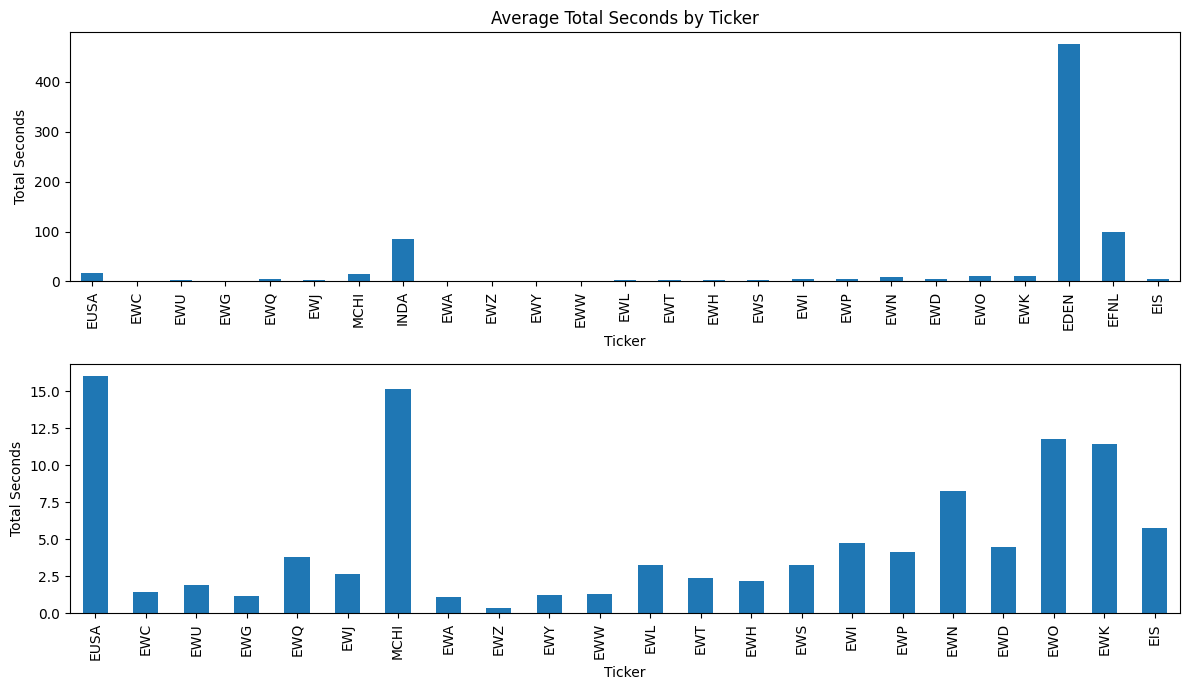

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

average_diff_seconds.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[0], legend=False)
axs[0].set_title('Average Total Seconds by Ticker')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Total Seconds')
axs[0].tick_params(axis='x', rotation=90)

#Plot without the outliers
average_diff_seconds_clean.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[1], legend=False)

axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Total Seconds')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Epps Effect

Here the Epps Effect is computed for different pairs of data

In [ ]:
import numpy as np

def plot_epps_effect(asset_1, asset_2, save_address = None, percentile = None):
    # read from clean data into polars

    asset_1_df = pl.read_parquet(f"Data/clean/{asset_1}.parquet")
    asset_2_df = pl.read_parquet(f"Data/clean/{asset_2}.parquet")

    asset_1_df = asset_1_df.with_columns(asset_1_df["weighted-avg-price"].alias(f"price_{asset_1}"))
    asset_2_df = asset_2_df.with_columns(asset_2_df["weighted-avg-price"].alias(f"price_{asset_2}"))

    asset_1_df.drop_in_place("weighted-avg-price")
    asset_2_df.drop_in_place("weighted-avg-price")

    merged = asset_1_df.join(asset_2_df, on="time-bucket", how="inner")

    if percentile:
        merged = merged.to_pandas()
        thresholds = merged.drop(columns = ["time-bucket"]).abs().quantile(percentile / 100)
        merged = merged.apply(lambda col: col.where(col.abs() <= thresholds[col.name]) if col.name != "time-bucket"else col)
        merged = merged.dropna()
        merged = pl.DataFrame(merged)
    
    delta_t = np.arange(1, 1000, 1)
    correlations = []
    for t in tqdm(delta_t):
        rows_to_keep = np.arange(0, merged.height, t)
        temp = merged[rows_to_keep]
        # calculate returns for price columns
        temp = temp.with_columns(
            (temp[f"price_{asset_1}"] / temp[f"price_{asset_1}"].shift(1) - 1).alias(f"return_{asset_1}"),
            (temp[f"price_{asset_2}"] / temp[f"price_{asset_2}"].shift(1) - 1).alias(f"return_{asset_2}")
        )
        # calculate correlation
        correlation = temp.select(pl.corr(f"return_{asset_1}", f"return_{asset_2}")).item(0, 0)
        correlations.append(correlation)
    delta_t *= 5  # 5 seconds per row
    
    plt.scatter(list(delta_t), correlations)
    plt.xlabel(r"$\Delta t$ seconds", fontdict={"size": 14})

    plt.ylabel("Correlation", fontdict={"size": 14})
    plt.title(f"Epps Effect for {asset_1} and {asset_2}", fontdict={"size": 16})
    if save_address:
        plt.savefig(save_address)

100%|██████████| 999/999 [00:03<00:00, 292.45it/s]


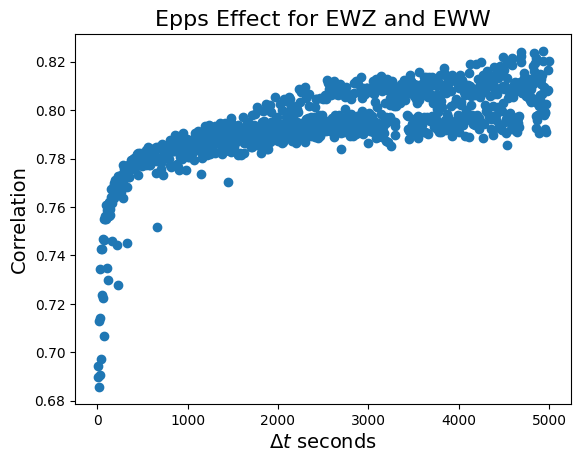

In [ ]:
plot_epps_effect("EWZ", "EWW", "EWZ_EWW_epps.png")

100%|██████████| 999/999 [00:04<00:00, 242.48it/s]


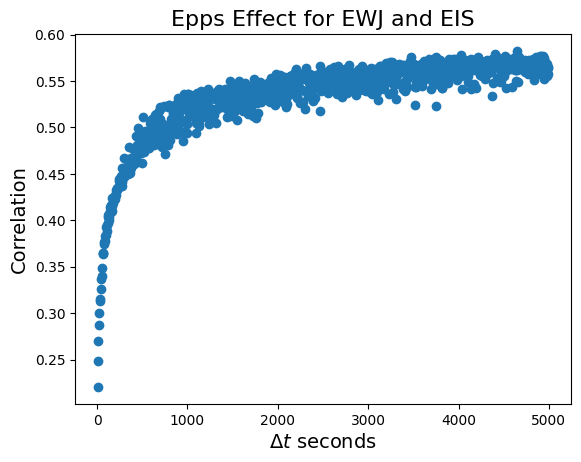

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps.png")

100%|██████████| 999/999 [00:02<00:00, 455.35it/s]


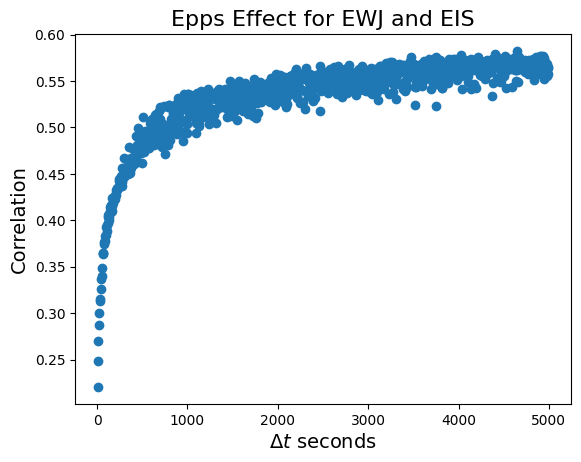

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps.png")

100%|██████████| 999/999 [00:02<00:00, 422.89it/s]


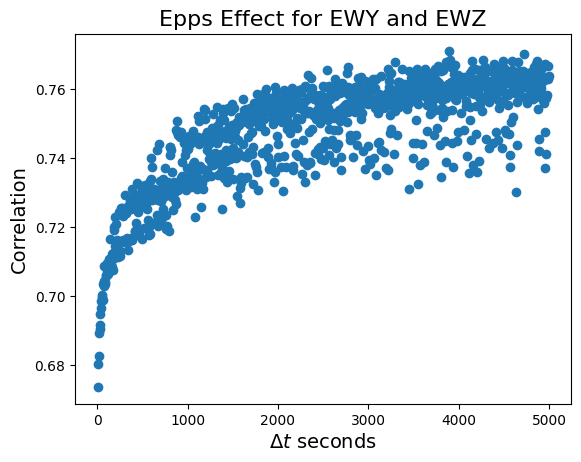

In [ ]:
plot_epps_effect("EWY", "EWZ", "EWY_EWZ_epps_99.png", percentile=99)

100%|██████████| 999/999 [00:02<00:00, 423.85it/s]


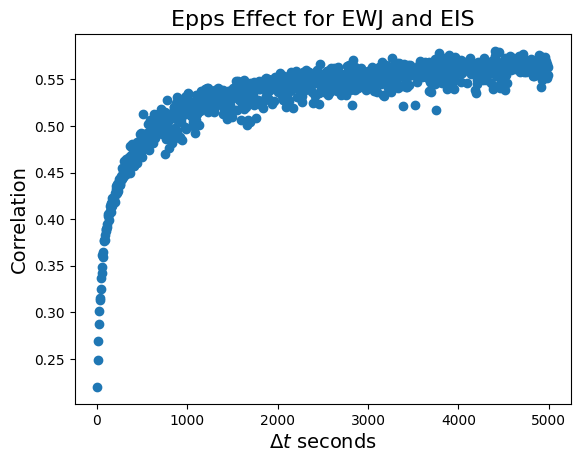

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps_99.png", percentile=99)

100%|██████████| 999/999 [00:02<00:00, 428.62it/s]


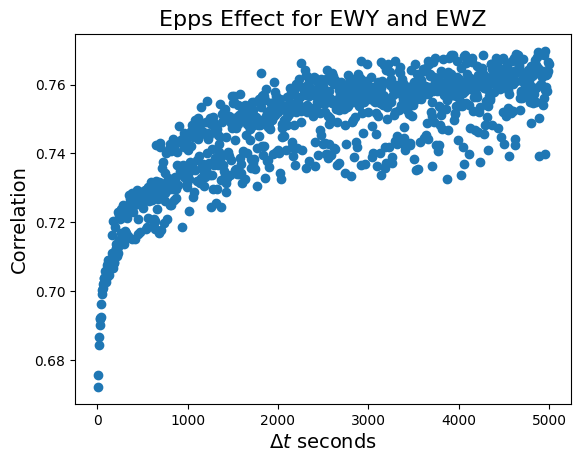

In [ ]:
plot_epps_effect("EWY", "EWZ", "EWY_EWZ_epps_95.png", percentile=95)

100%|██████████| 999/999 [00:02<00:00, 441.77it/s]


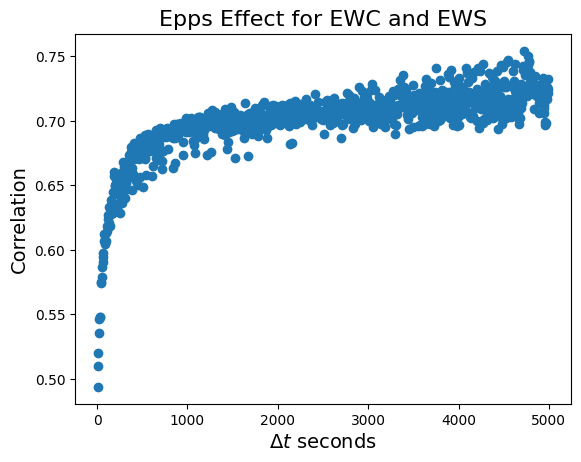

In [ ]:
plot_epps_effect("EWC", "EWS", "EWC_EWS_epps_95.png", percentile=95)

# Correlation and Flash Crash

In [2]:
Countries_indexes = ["EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"]

### Function to create dataframe of returns

In [3]:
file_path_template = "Data/clean/{}.parquet"

def compute_returns(df, price_col="weighted-avg-price", lag=1):
    return df.with_columns(
        (pl.col(price_col).diff(lag) / pl.col(price_col).shift(lag)).alias("return")
    ).drop_nulls(subset=["return"])

## Full DataSet

In [4]:
all_returns_df = pd.DataFrame()

# Populate the DataFrame with returns for each asset
for asset in Countries_indexes:
    file_path = file_path_template.format(asset)
    df = pl.read_parquet(file_path)
    df_returns = compute_returns(df)

    if "time-bucket" in df.columns:
        time_bucket = df["time-bucket"].to_pandas()
        if "time-bucket" not in all_returns_df.columns:
            all_returns_df["time-bucket"] = time_bucket
    
    all_returns_df[asset] = df_returns["return"].to_pandas()

print(all_returns_df.shape)

percentile_threshold = 100
thresholds = all_returns_df.drop(columns=["time-bucket"]).abs().quantile(percentile_threshold / 100)
all_returns_df = all_returns_df.apply(
    lambda col: col.where(col.abs() <= thresholds[col.name]) if col.name != "time-bucket" else col
)

all_returns_df = all_returns_df.dropna()

mat_for_corr = all_returns_df.drop(columns=["time-bucket"])
correlation_matrix = mat_for_corr.corr()

print(all_returns_df.shape)


(3988727, 20)
(3988726, 20)


### Heatmap

/var/folders/j8/h6ghxfbx1871ncs72q_7x3w80000gn/T/ipykernel_68853/2923769743.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


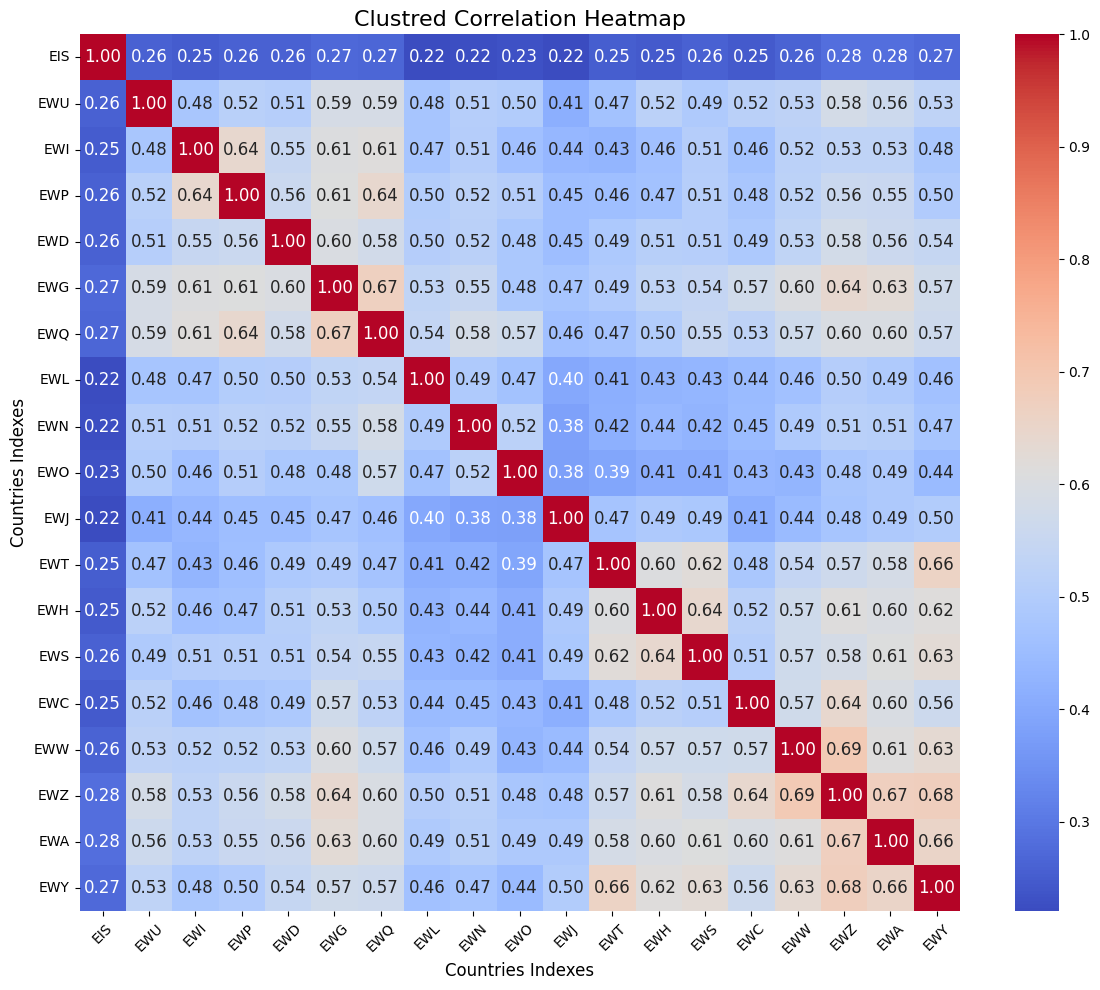

In [5]:
# Convert the correlation matrix to a distance matrix for clustering
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Reorder the correlation matrix and labels
clustered_matrix = correlation_matrix.to_numpy()[np.ix_(ordered_indices, ordered_indices)]
ordered_labels = [mat_for_corr.columns[i] for i in ordered_indices]

# Plot the heatmap without dendrogram
plt.figure(figsize=(12, 10))
sns.heatmap(
    clustered_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    annot_kws={"size": 12}
)

plt.title("Clustred Correlation Heatmap", fontsize=16)
plt.xlabel("Countries Indexes", fontsize=12)
plt.ylabel("Countries Indexes", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### highest and lowest correlation in absolute value

In [6]:
correlation_matrix_df = pd.DataFrame(
    correlation_matrix,
    index=Countries_indexes,
    columns=Countries_indexes
)

abs_corr_values = correlation_matrix_df.abs()
np.fill_diagonal(abs_corr_values.values, 0)  # Set diagonal to 0 for highest/lowest calculation

max_pair_indices = np.unravel_index(abs_corr_values.values.argmax(), abs_corr_values.shape)
highest_corr_final = {
    "countries": (Countries_indexes[max_pair_indices[0]], Countries_indexes[max_pair_indices[1]]),
    "value": correlation_matrix_df.iloc[max_pair_indices]
}

abs_corr_no_diag = abs_corr_values.copy()
np.fill_diagonal(abs_corr_no_diag.values, np.nan)  # Set diagonal to NaN

min_pair_corrected_indices = np.unravel_index(np.nanargmin(abs_corr_no_diag.values), abs_corr_no_diag.shape)
lowest_corr_corrected = {
    "countries": (Countries_indexes[min_pair_corrected_indices[0]], Countries_indexes[min_pair_corrected_indices[1]]),
    "value": correlation_matrix_df.iloc[min_pair_corrected_indices]
}

print("Highest Absolute Correlation:")
print(highest_corr_final)
print("\nLowest Absolute Correlation (excluding self-correlation):")
print(lowest_corr_corrected)

Highest Absolute Correlation:
{'countries': ('EWW', 'EWZ'), 'value': 0.6899055637798814}

Lowest Absolute Correlation (excluding self-correlation):
{'countries': ('EWJ', 'EIS'), 'value': 0.22064814816773456}


### Lead Lag Plots

In [7]:
def cross_correlation_lags(arr1, arr2, max_lag=100):
    """
    Computes correlation at all integer lags from -max_lag to +max_lag.
    
    Returns
    -------
    lags : np.ndarray of shape (2*max_lag+1,)
        The lag values (negative to positive).
    corrs : np.ndarray of shape (2*max_lag+1,)
        The correlation for each lag.
    """
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        if lag < 0:
            # Example: lag = -5 => arr2 is 'ahead' of arr1 by 5 steps
            offset = -lag
            x1 = arr1[:len(arr1) - offset]
            x2 = arr2[offset:]
        elif lag > 0:
            # Example: lag = +5 => arr2 is 'behind' arr1 by 5 steps
            x1 = arr1[lag:]
            x2 = arr2[:len(arr2) - lag]
        else:
            # lag == 0 => no shift
            x1 = arr1
            x2 = arr2

        if len(x1) > 1 and len(x1) == len(x2):
            corr = np.corrcoef(x1, x2)[0, 1]
        else:
            corr = np.nan
        corrs.append(corr)

    return lags, np.array(corrs)


In [8]:
def compute_and_plot_for_pairs_combined(pairs, all_returns_df, max_lag=30, percentile=None):
    """
    Compute and plot cross-correlation for specific pairs and years in a single plot.

    Parameters:
        pairs (list of tuples): List of asset pairs (e.g., [("EWW", "EWZ"), ("EWJ", "EIS")]).
        all_returns_df (pd.DataFrame): DataFrame containing the returns and "time-bucket" column.
        max_lag (int): Maximum lag to compute cross-correlation.
        percentile (int or None): Percentile value to include in the plot title, if applicable.

    Returns:
        None
    """
    # Ensure "time-bucket" is datetime and extract year
    all_returns_df["time-bucket"] = pd.to_datetime(all_returns_df["time-bucket"])
    all_returns_df["year"] = all_returns_df["time-bucket"].dt.year

    for pair in pairs:
        asset1, asset2 = pair
        plt.figure(figsize=(10, 6))
        
        for year, color in zip([2009, 2012], ['blue', 'orange']):
            year_data = all_returns_df[all_returns_df["year"] == year]

            series1 = np.array(year_data[asset1].dropna())
            series2 = np.array(year_data[asset2].dropna())

            if len(series1) == 0 or len(series2) == 0:
                print(f"No data for {asset1} and {asset2} in {year}")
                continue

            # Compute cross-correlation
            lags, correlations = cross_correlation_lags(series1, series2, max_lag)

            # Plot for the specific year
            plt.plot(lags, correlations, marker='o', label=f"{year}", color=color)

        # Add title and labels
        title = f"Cross-correlation vs. Lag: {asset1} & {asset2}"
        if percentile is not None:
            title += f" - {percentile}th Percentile"
        plt.title(title)
        
        plt.xlabel("Lag (buckets)")
        plt.ylabel("Correlation")
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.legend()
        plt.grid(True)
        plt.show()


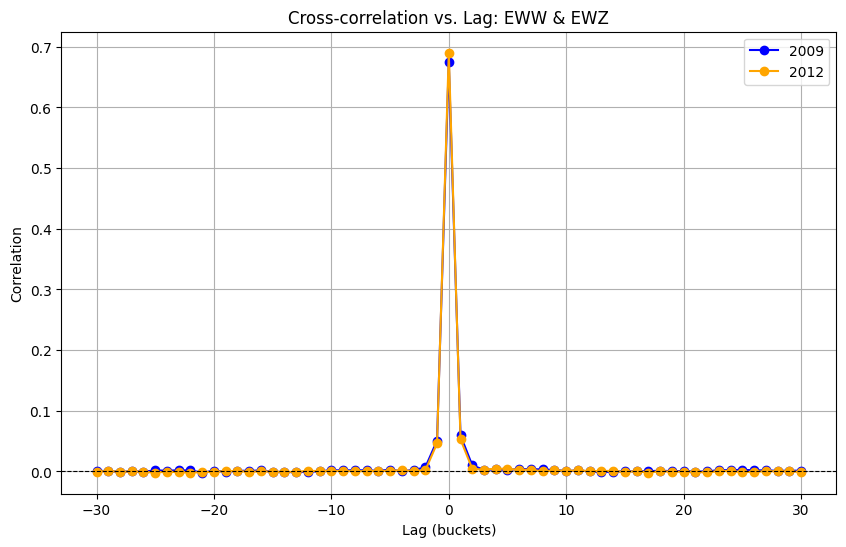

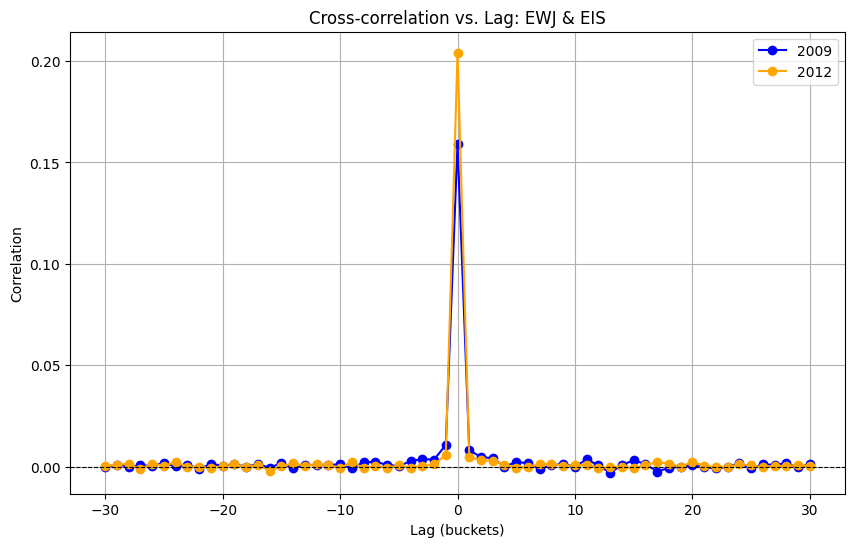

In [9]:
specific_pairs = [("EWW", "EWZ"), ("EWJ", "EIS")]

compute_and_plot_for_pairs_combined(specific_pairs, all_returns_df, max_lag=30, percentile=None)

### Rolling Correlation

In [10]:
def rolling_cross_correlation_for_pairs(pairs, all_returns_df, window_length, delta_step=5):
    """
    Compute rolling cross-correlation for specific pairs and save output as a dictionary of DataFrames.
    
    Parameters:
    - pairs: List of tuples representing asset pairs (e.g., [("EWW", "EWZ"), ("EWJ", "EIS")])
    - all_returns_df: DataFrame containing the returns for all assets
    - window_length: Size of the rolling window
    - delta_step: Sliding window step size
    
    Returns:
    A dictionary where keys are asset pairs and values are DataFrames with 'window_start' and 'correlation' columns.
    """
    results = {}
    
    for pair in pairs:
        asset1, asset2 = pair
        
        if asset1 not in all_returns_df.columns or asset2 not in all_returns_df.columns:
            print(f"Skipping pair {asset1}, {asset2}: One or both assets not in the DataFrame.")
            continue
        
        # Get the arrays for the two assets
        arr1 = np.array(all_returns_df[asset1].dropna())
        arr2 = np.array(all_returns_df[asset2].dropna())
        
        if len(arr1) != len(arr2):
            print(f"Skipping pair {asset1}, {asset2}: Arrays have different lengths after removing NaNs.")
            continue
        
        # Compute rolling cross-correlation
        correlations = []
        window_starts = []
        for start in range(0, len(arr1) - window_length + 1, delta_step):
            end = start + window_length
            
            window1 = arr1[start:end]
            window2 = arr2[start:end]
            
            correlation = np.corrcoef(window1, window2)[0, 1]
            
            correlations.append(correlation)
            window_starts.append(start)
        
        result_df = pd.DataFrame({
            "window_start": window_starts,
            "correlation": correlations
        })
        results[pair] = result_df
    
    return results

In [11]:
# # Compute rolling correlations
rolling_corr_results = rolling_cross_correlation_for_pairs(specific_pairs, all_returns_df, window_length=60, delta_step=5)


/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


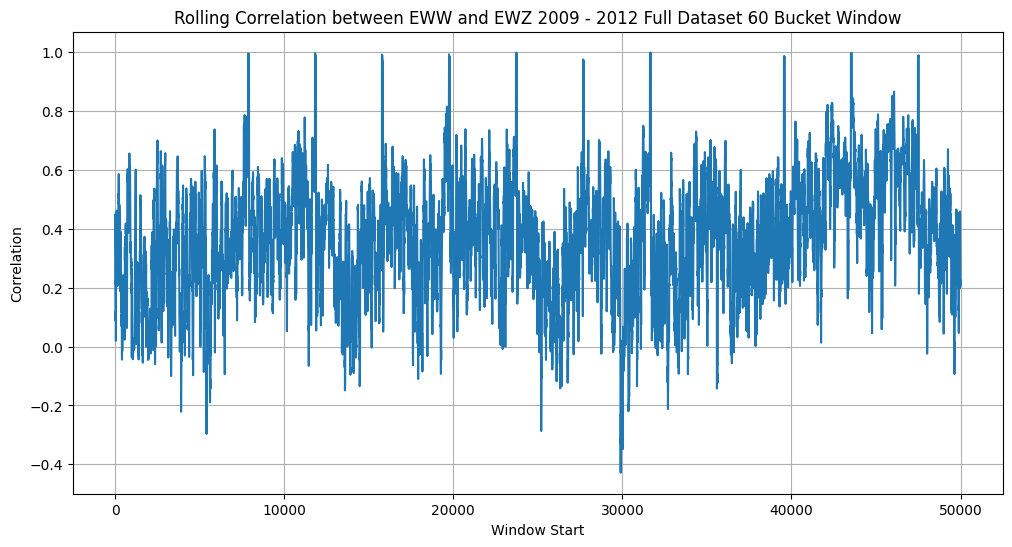

In [12]:
# Plot results for one pair
selected_pair = ("EWW", "EWZ")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(10000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 Full Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")


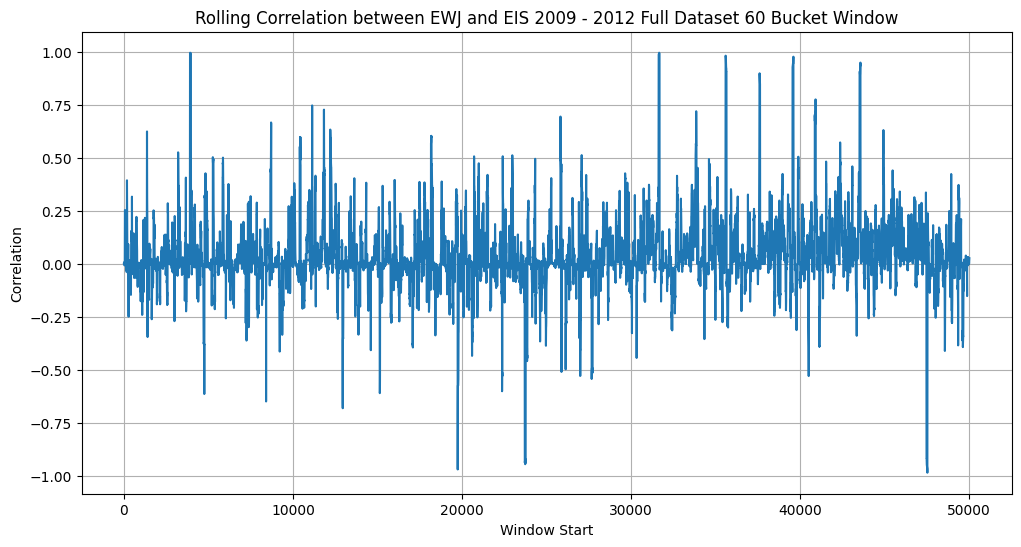

In [13]:
# Plot results for one pair
selected_pair = ("EWJ", "EIS")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(10000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 Full Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")


## Flash crash day

In [14]:
def rolling_cross_correlation_for_specific_dates(
    pairs, all_returns_df, window_length, delta_step, specific_dates
):
    """
    Compute rolling cross-correlation for specific pairs and filter by specific dates.
    
    Parameters:
    - pairs: List of tuples representing asset pairs (e.g., [("EWW", "EWZ"), ("EWJ", "EIS")])
    - all_returns_df: DataFrame containing the returns for all assets
    - window_length: Size of the rolling window
    - delta_step: Sliding window step size
    - specific_dates: List of specific dates to filter data (e.g., ['2010-05-06', '2011-05-06'])
    
    Returns:
    A dictionary where keys are asset pairs and values are dictionaries of DataFrames 
    for each specific date with 'window_start' and 'correlation' columns.
    """
    results = {pair: {} for pair in pairs}
    
    for pair in pairs:
        asset1, asset2 = pair
        
        if asset1 not in all_returns_df.columns or asset2 not in all_returns_df.columns:
            print(f"Skipping pair {asset1}, {asset2}: One or both assets not in the DataFrame.")
            continue
        
        for date in specific_dates:
            # Filter data for the specific date
            date_data = all_returns_df[
                all_returns_df["time-bucket"].dt.date == pd.to_datetime(date).date()
            ]
            
            arr1 = np.array(date_data[asset1].dropna())
            arr2 = np.array(date_data[asset2].dropna())
            
            if len(arr1) != len(arr2):
                print(f"Skipping pair {asset1}, {asset2} on {date}: Arrays have different lengths.")
                continue
            
            # Compute rolling cross-correlation
            correlations = []
            window_starts = []
            for start in range(0, len(arr1) - window_length + 1, delta_step):
                end = start + window_length
                
                window1 = arr1[start:end]
                window2 = arr2[start:end]
                
                correlation = np.corrcoef(window1, window2)[0, 1]
                
                correlations.append(correlation)
                window_starts.append(start)
            
            result_df = pd.DataFrame({
                "window_start": window_starts,
                "correlation": correlations
            })
            results[pair][date] = result_df
    
    return results

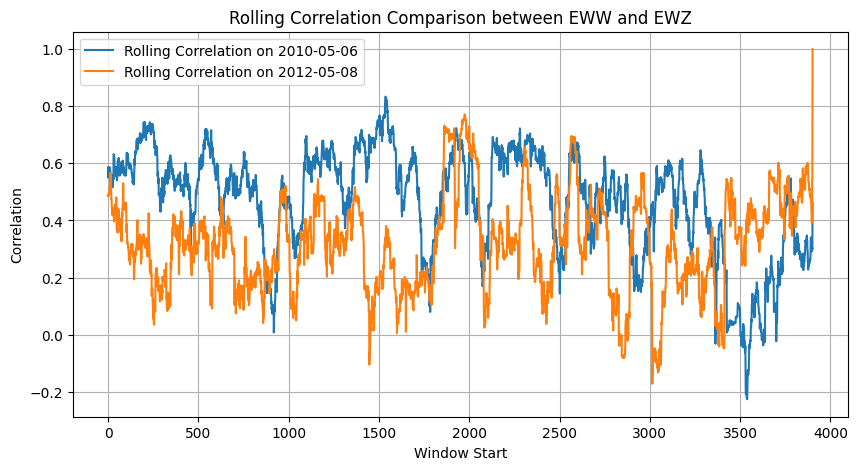

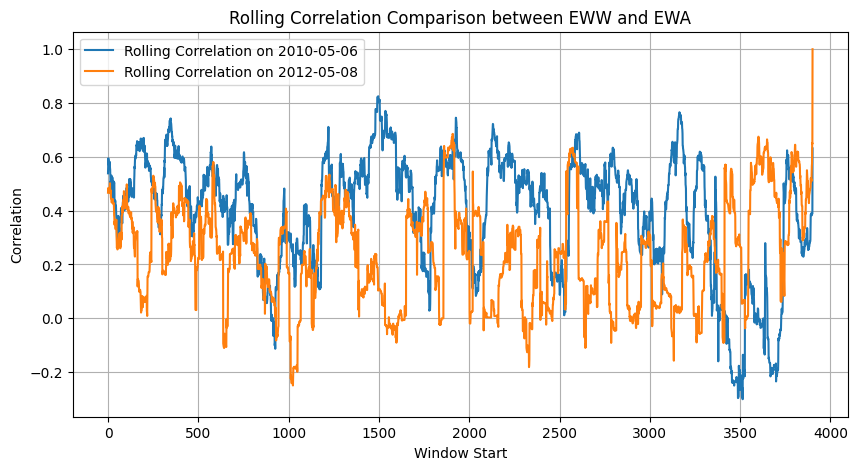

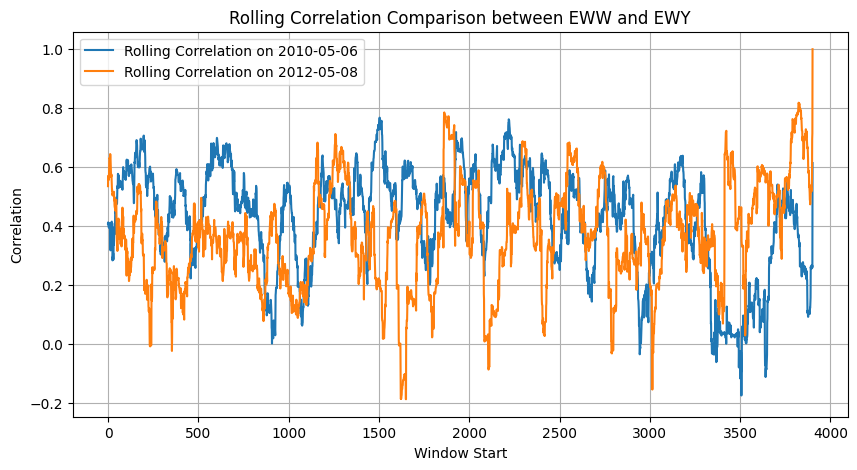

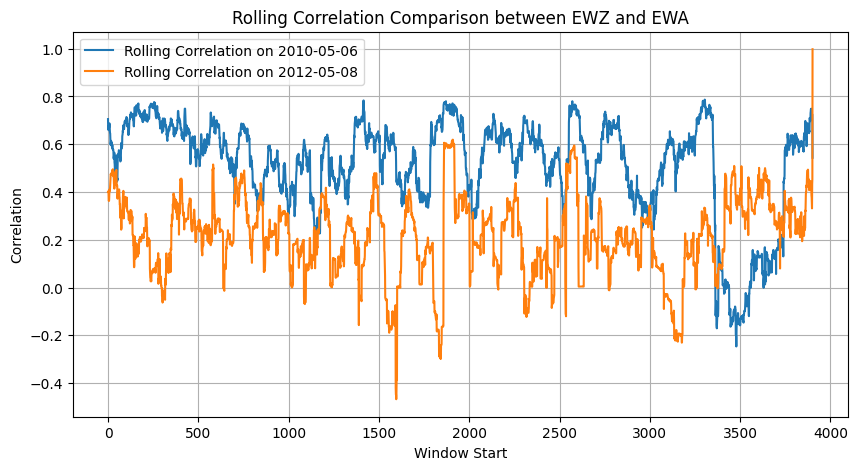

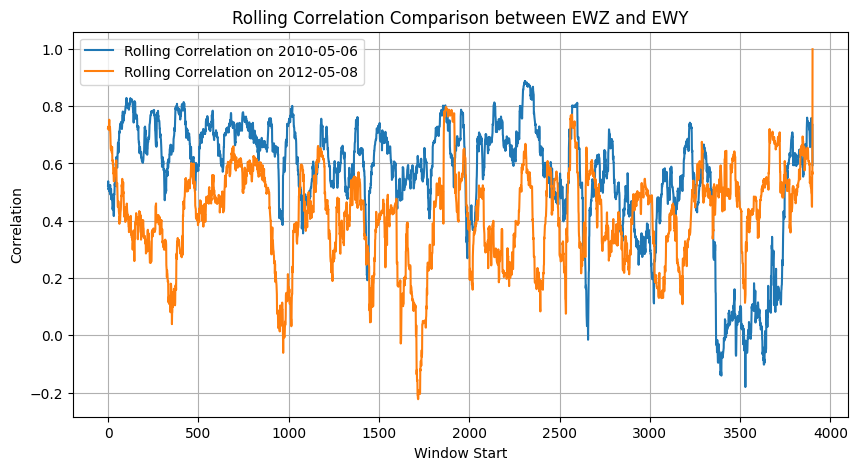

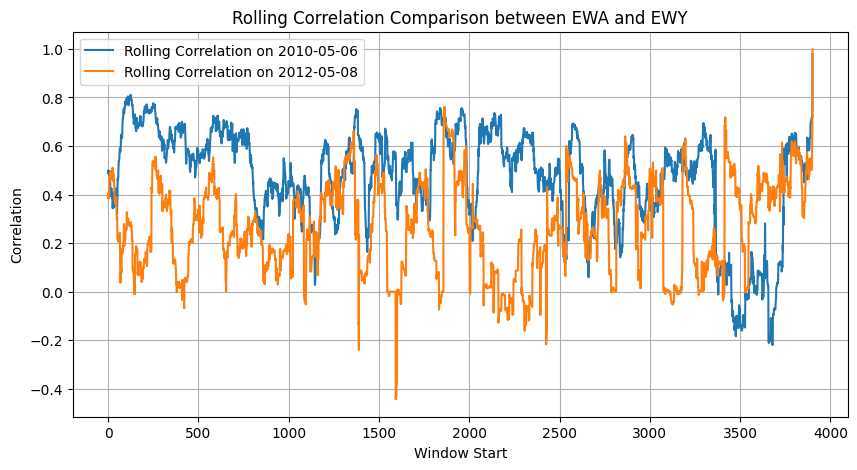

In [15]:
# Plot results for all pairs
specific_pairs = [('EWW', 'EWZ'), ('EWW', 'EWA'), ('EWW', 'EWY'), ('EWZ', 'EWA'), ('EWZ', 'EWY'), ('EWA', 'EWY')]
specific_dates = ["2010-05-06", "2012-05-08"]

# Generate rolling correlations
rolling_corr_results = rolling_cross_correlation_for_specific_dates(
    pairs=specific_pairs,
    all_returns_df=all_returns_df,
    window_length=60,
    delta_step=1,
    specific_dates=specific_dates
)

for selected_pair in specific_pairs:
    if selected_pair in rolling_corr_results:
        plt.figure(figsize=(10, 5))
        
        # Plot for each date
        for date, rolling_corr_df in rolling_corr_results[selected_pair].items():
            rolling_corr_df = rolling_corr_df.dropna()
            plt.plot(
                rolling_corr_df['window_start'], 
                rolling_corr_df['correlation'], 
                label=f"Rolling Correlation on {date}"
            )
        
        plt.title(f'Rolling Correlation Comparison between {selected_pair[0]} and {selected_pair[1]}')
        plt.xlabel('Window Start')
        plt.ylabel('Correlation')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results found for pair {selected_pair}.")

## 99th percentile

In [16]:
all_returns_df = pd.DataFrame()

# Populate the DataFrame with returns for each asset
for asset in Countries_indexes:
    file_path = file_path_template.format(asset)
    df = pl.read_parquet(file_path)
    df_returns = compute_returns(df)

    if "time-bucket" in df.columns:
        time_bucket = df["time-bucket"].to_pandas()
        if "time-bucket" not in all_returns_df.columns:
            all_returns_df["time-bucket"] = time_bucket
    
    all_returns_df[asset] = df_returns["return"].to_pandas()

print(all_returns_df.shape)

percentile_threshold = 99
thresholds = all_returns_df.drop(columns=["time-bucket"]).abs().quantile(percentile_threshold / 100)
all_returns_df = all_returns_df.apply(
    lambda col: col.where(col.abs() <= thresholds[col.name]) if col.name != "time-bucket" else col
)

all_returns_df = all_returns_df.dropna()

mat_for_corr = all_returns_df.drop(columns=["time-bucket"])
correlation_matrix = mat_for_corr.corr()

print(all_returns_df.shape)


(3988727, 20)
(3533964, 20)


### Heatmap

/var/folders/j8/h6ghxfbx1871ncs72q_7x3w80000gn/T/ipykernel_68853/2923769743.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


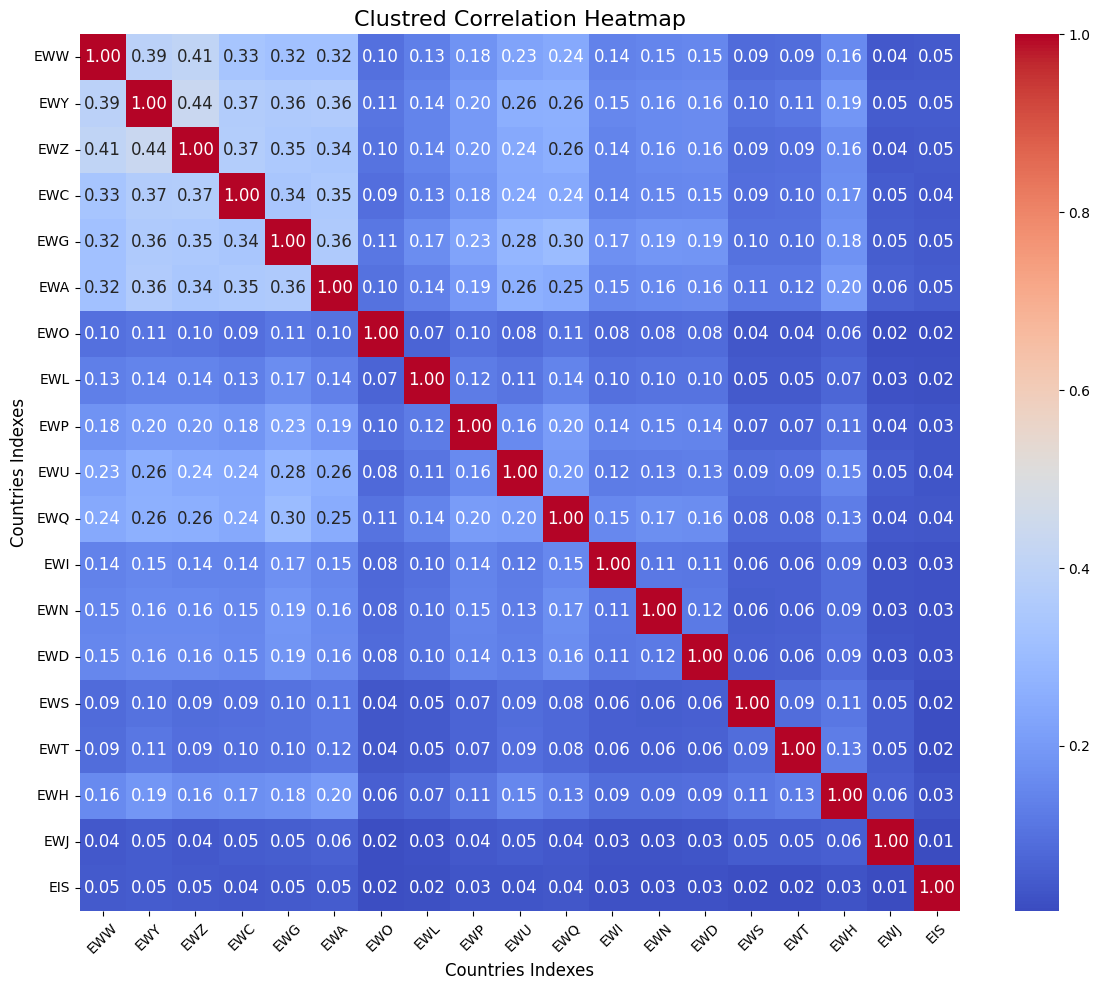

In [17]:
# Convert the correlation matrix to a distance matrix for clustering
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Reorder the correlation matrix and labels
clustered_matrix = correlation_matrix.to_numpy()[np.ix_(ordered_indices, ordered_indices)]
ordered_labels = [mat_for_corr.columns[i] for i in ordered_indices]

# Plot the heatmap without dendrogram
plt.figure(figsize=(12, 10))
sns.heatmap(
    clustered_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    annot_kws={"size": 12}
)

plt.title("Clustred Correlation Heatmap", fontsize=16)
plt.xlabel("Countries Indexes", fontsize=12)
plt.ylabel("Countries Indexes", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### highest and lowest correlation in absolute value

In [18]:
correlation_matrix_df = pd.DataFrame(
    correlation_matrix,
    index=Countries_indexes,
    columns=Countries_indexes
)

abs_corr_values = correlation_matrix_df.abs()
np.fill_diagonal(abs_corr_values.values, 0)  # Set diagonal to 0 for highest/lowest calculation

max_pair_indices = np.unravel_index(abs_corr_values.values.argmax(), abs_corr_values.shape)
highest_corr_final = {
    "countries": (Countries_indexes[max_pair_indices[0]], Countries_indexes[max_pair_indices[1]]),
    "value": correlation_matrix_df.iloc[max_pair_indices]
}

abs_corr_no_diag = abs_corr_values.copy()
np.fill_diagonal(abs_corr_no_diag.values, np.nan)  # Set diagonal to NaN

min_pair_corrected_indices = np.unravel_index(np.nanargmin(abs_corr_no_diag.values), abs_corr_no_diag.shape)
lowest_corr_corrected = {
    "countries": (Countries_indexes[min_pair_corrected_indices[0]], Countries_indexes[min_pair_corrected_indices[1]]),
    "value": correlation_matrix_df.iloc[min_pair_corrected_indices]
}

print("Highest Absolute Correlation:")
print(highest_corr_final)
print("\nLowest Absolute Correlation (excluding self-correlation):")
print(lowest_corr_corrected)

Highest Absolute Correlation:
{'countries': ('EWY', 'EWZ'), 'value': 0.43748294569159524}

Lowest Absolute Correlation (excluding self-correlation):
{'countries': ('EWJ', 'EIS'), 'value': 0.014172011832895645}


### Lead Lag Plots


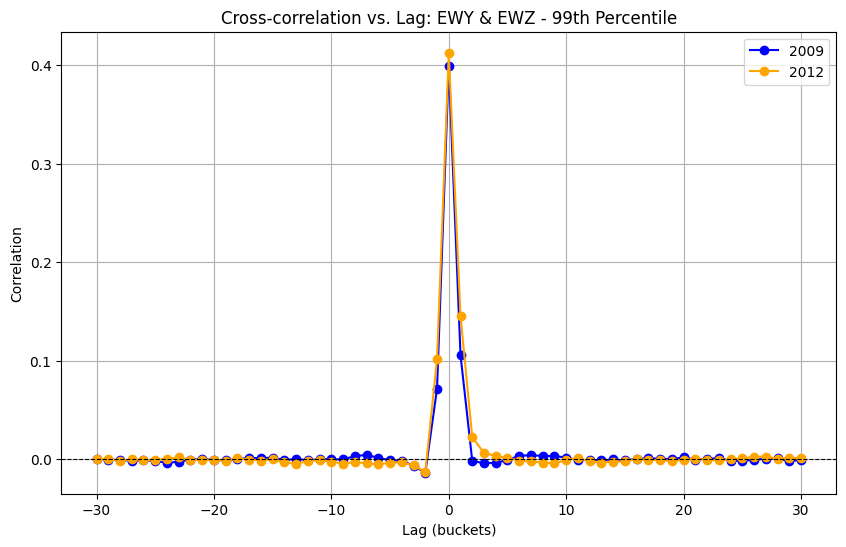

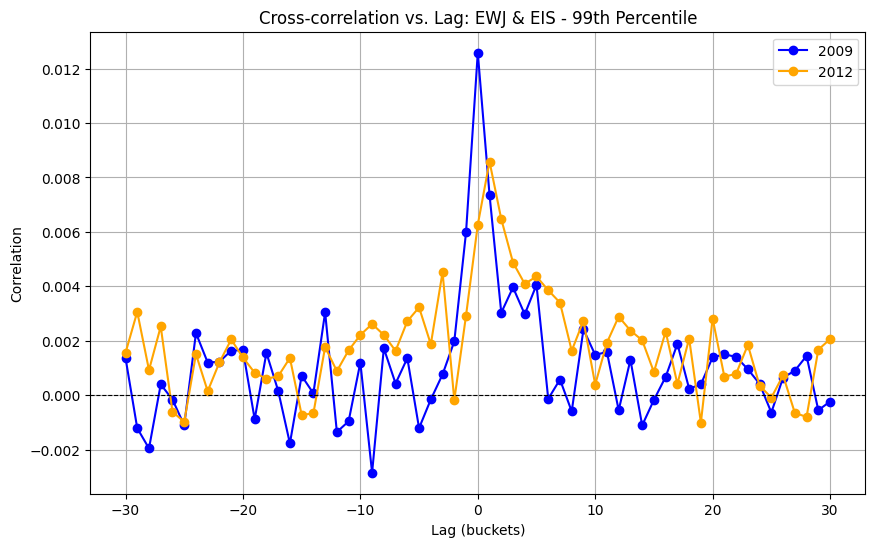

In [19]:
specific_pairs = [("EWY", "EWZ"), ("EWJ", "EIS")]

compute_and_plot_for_pairs_combined(specific_pairs, all_returns_df, max_lag=30, percentile=percentile_threshold)

### Rolling Correlation

/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


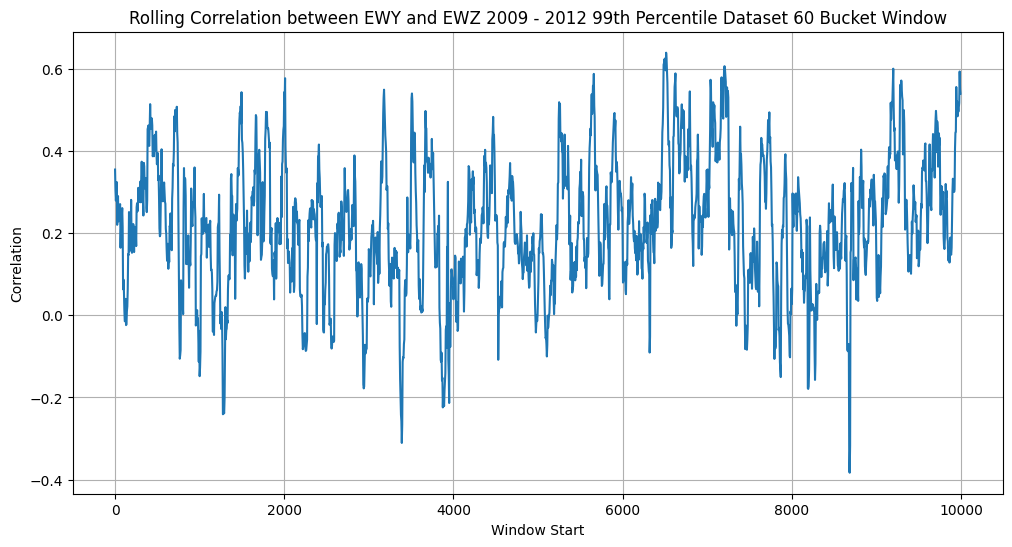

In [20]:
rolling_corr_results = rolling_cross_correlation_for_pairs(specific_pairs, all_returns_df, window_length=60, delta_step=5)

# Plot results for one pair
selected_pair = ("EWY", "EWZ")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(2000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 99th Percentile Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")

/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


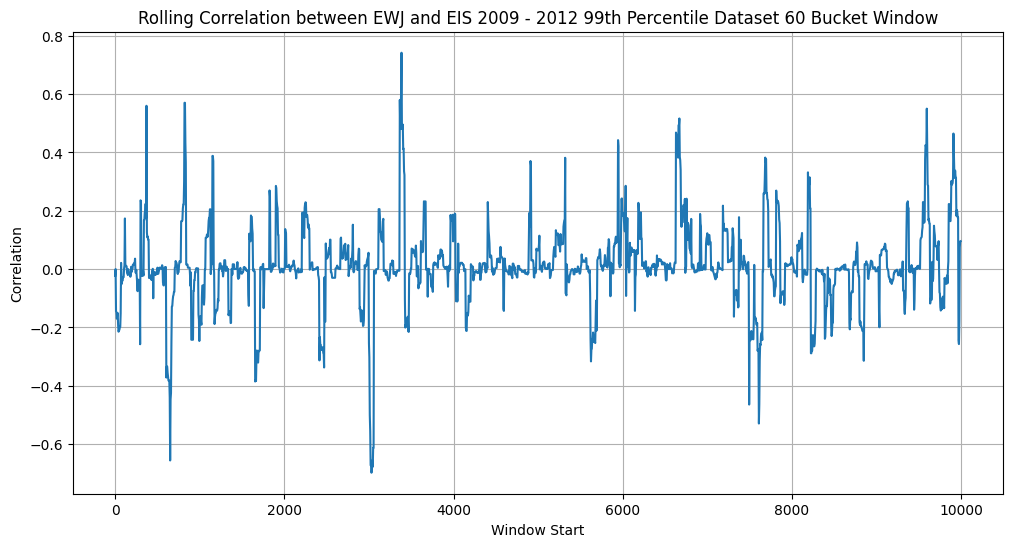

In [21]:
rolling_corr_results = rolling_cross_correlation_for_pairs(specific_pairs, all_returns_df, window_length=60, delta_step=5)

# Plot results for one pair
selected_pair = ("EWJ", "EIS")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(2000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 99th Percentile Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")

## 95th percentile

In [22]:
all_returns_df = pd.DataFrame()

# Populate the DataFrame with returns for each asset
for asset in Countries_indexes:
    file_path = file_path_template.format(asset)
    df = pl.read_parquet(file_path)
    df_returns = compute_returns(df)

    if "time-bucket" in df.columns:
        time_bucket = df["time-bucket"].to_pandas()
        if "time-bucket" not in all_returns_df.columns:
            all_returns_df["time-bucket"] = time_bucket
    
    all_returns_df[asset] = df_returns["return"].to_pandas()

print(all_returns_df.shape)

percentile_threshold = 95
thresholds = all_returns_df.drop(columns=["time-bucket"]).abs().quantile(percentile_threshold / 100)
all_returns_df = all_returns_df.apply(
    lambda col: col.where(col.abs() <= thresholds[col.name]) if col.name != "time-bucket" else col
)

all_returns_df = all_returns_df.dropna()

mat_for_corr = all_returns_df.drop(columns=["time-bucket"])
correlation_matrix = mat_for_corr.corr()

print(all_returns_df.shape)


(3988727, 20)
(2310101, 20)


### Heatmap

/var/folders/j8/h6ghxfbx1871ncs72q_7x3w80000gn/T/ipykernel_68853/2923769743.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


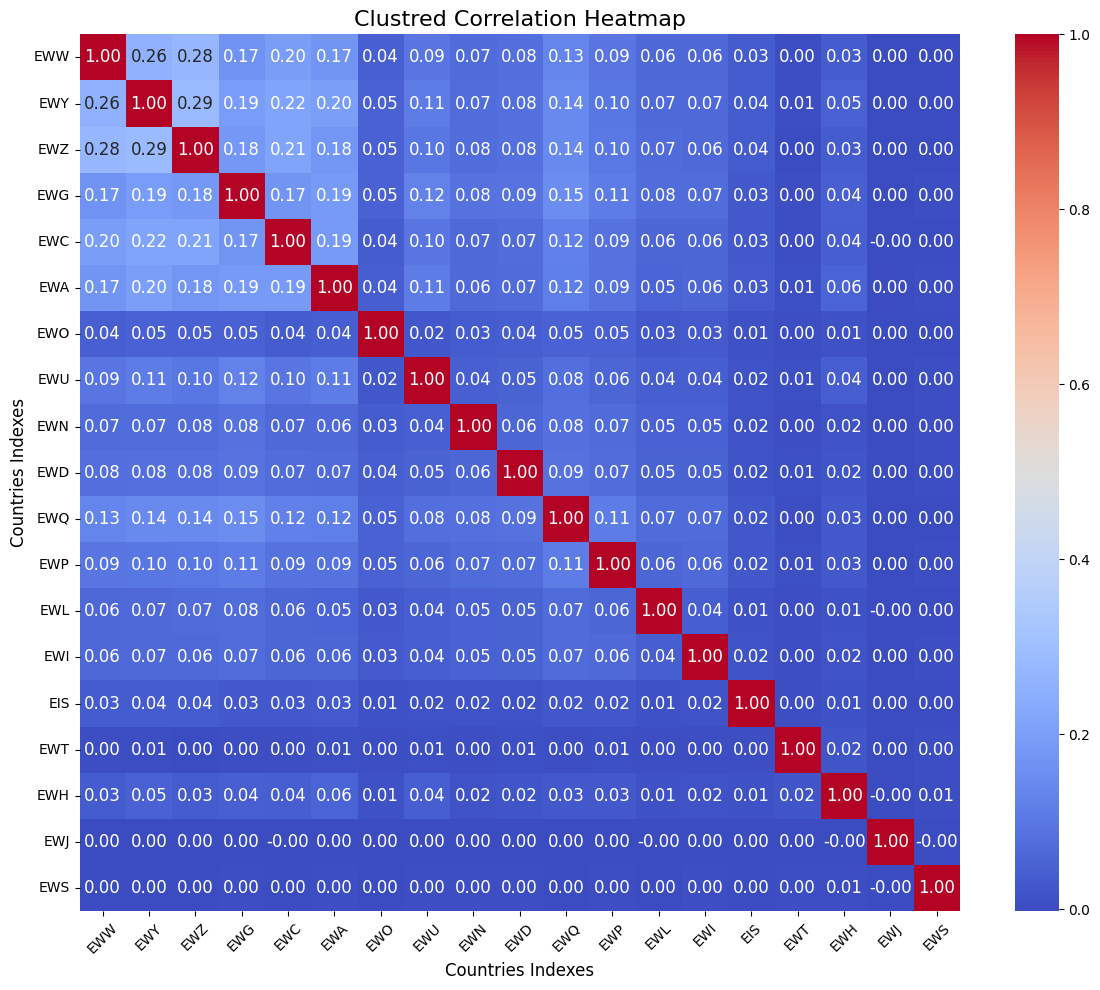

In [23]:
# Convert the correlation matrix to a distance matrix for clustering
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Reorder the correlation matrix and labels
clustered_matrix = correlation_matrix.to_numpy()[np.ix_(ordered_indices, ordered_indices)]
ordered_labels = [mat_for_corr.columns[i] for i in ordered_indices]

# Plot the heatmap without dendrogram
plt.figure(figsize=(12, 10))
sns.heatmap(
    clustered_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    annot_kws={"size": 12}
)

plt.title("Clustred Correlation Heatmap", fontsize=16)
plt.xlabel("Countries Indexes", fontsize=12)
plt.ylabel("Countries Indexes", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### highest and lowest correlation in absolute value

In [24]:
correlation_matrix_df = pd.DataFrame(
    correlation_matrix,
    index=Countries_indexes,
    columns=Countries_indexes
)

abs_corr_values = correlation_matrix_df.abs()
np.fill_diagonal(abs_corr_values.values, 0)  # Set diagonal to 0 for highest/lowest calculation

max_pair_indices = np.unravel_index(abs_corr_values.values.argmax(), abs_corr_values.shape)
highest_corr_final = {
    "countries": (Countries_indexes[max_pair_indices[0]], Countries_indexes[max_pair_indices[1]]),
    "value": correlation_matrix_df.iloc[max_pair_indices]
}

abs_corr_no_diag = abs_corr_values.copy()
np.fill_diagonal(abs_corr_no_diag.values, np.nan)  # Set diagonal to NaN

min_pair_corrected_indices = np.unravel_index(np.nanargmin(abs_corr_no_diag.values), abs_corr_no_diag.shape)
lowest_corr_corrected = {
    "countries": (Countries_indexes[min_pair_corrected_indices[0]], Countries_indexes[min_pair_corrected_indices[1]]),
    "value": correlation_matrix_df.iloc[min_pair_corrected_indices]
}

print("Highest Absolute Correlation:")
print(highest_corr_final)
print("\nLowest Absolute Correlation (excluding self-correlation):")
print(lowest_corr_corrected)

Highest Absolute Correlation:
{'countries': ('EWY', 'EWZ'), 'value': 0.28696370086871387}

Lowest Absolute Correlation (excluding self-correlation):
{'countries': ('EWC', 'EWS'), 'value': 6.122255336803162e-05}


### Lead Lag Plots

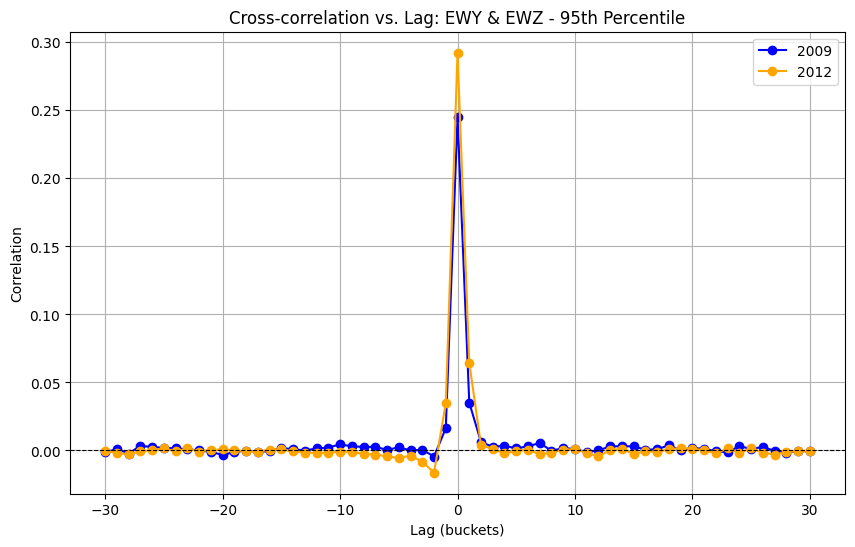

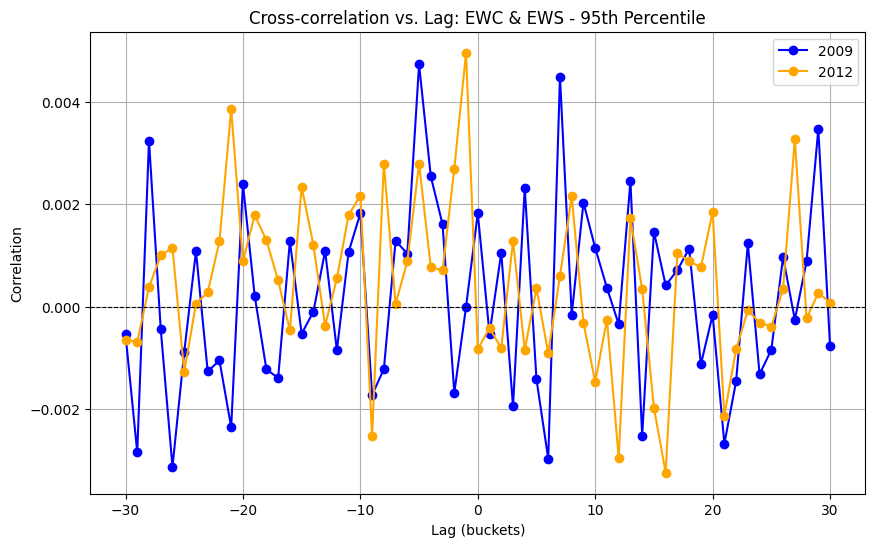

In [25]:
specific_pairs = [("EWY", "EWZ"), ("EWC", "EWS")]

compute_and_plot_for_pairs_combined(specific_pairs, all_returns_df, max_lag=30, percentile=percentile_threshold)

## Rolling Correlation

/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


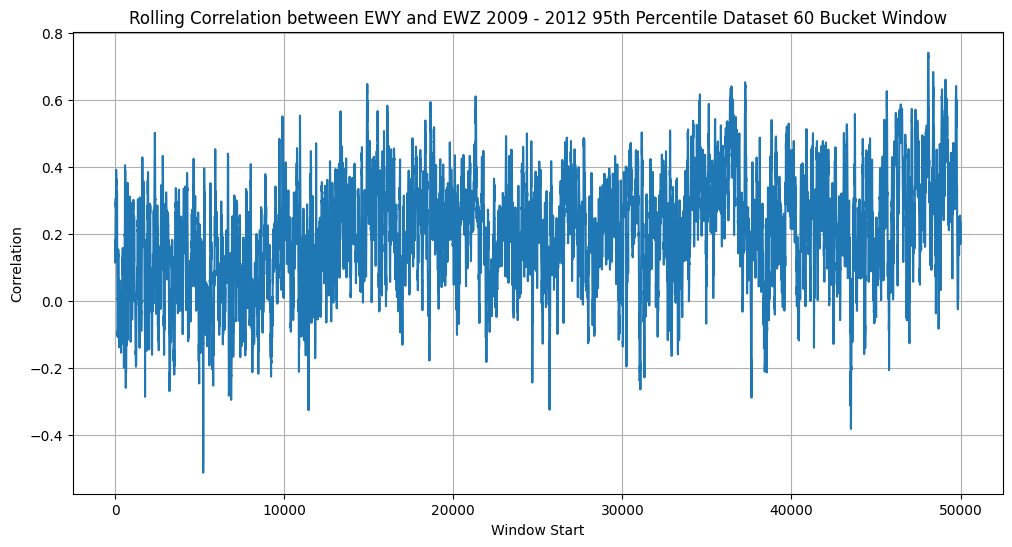

In [26]:
rolling_corr_results = rolling_cross_correlation_for_pairs(specific_pairs, all_returns_df, window_length=60, delta_step=5)

# Plot results for one pair
selected_pair = ("EWY", "EWZ")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(10000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 95th Percentile Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")

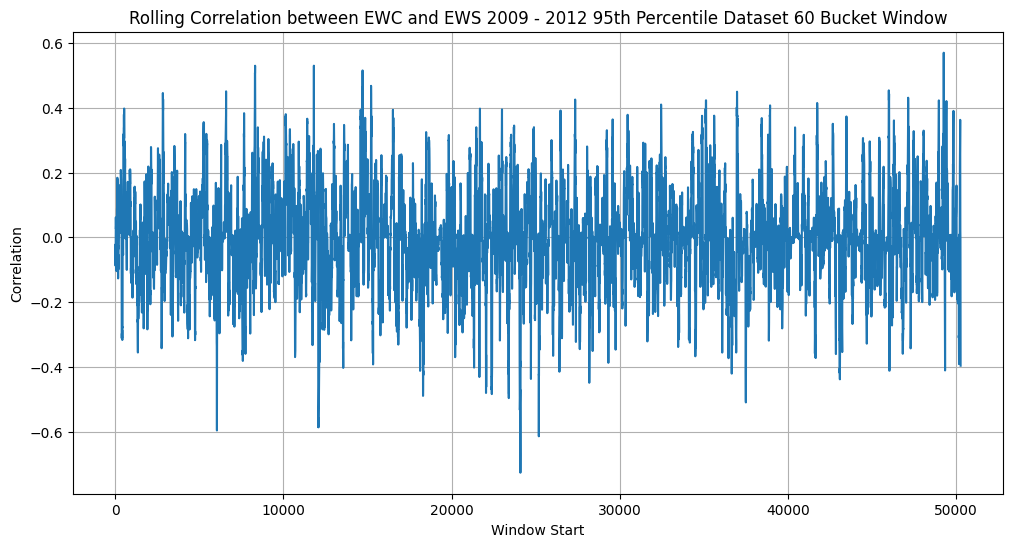

In [27]:
# Plot results for one pair
selected_pair = ("EWC", "EWS")
if selected_pair in rolling_corr_results:
    rolling_corr_df = rolling_corr_results[selected_pair].dropna()

    # Select the first 2000 observations
    first_obs = rolling_corr_df.head(10000)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(first_obs['window_start'], first_obs['correlation'])
    plt.title(f'Rolling Correlation between {selected_pair[0]} and {selected_pair[1]} 2009 - 2012 95th Percentile Dataset 60 Bucket Window')
    plt.xlabel('Window Start')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
else:
    print(f"No results found for pair {selected_pair}.")

# Compute covariance pairs

Assuming you have a folder of all the cleaned data under Data/clean/...

In [18]:
if demo:
    Countries_indexes = ["EWO", "EWG", "EWS"]
else:
    Countries_indexes = [ "EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"] 

In [19]:
final_df =  pl.read_parquet(f"Data/clean/{Countries_indexes[0]}.parquet")
print(f"Data for {Countries_indexes[0]}")
for country in Countries_indexes[1:]:
    df = pl.read_parquet(f"Data/clean/{country}.parquet")
    print(f"Data for {country}")
    final_df = final_df.join(df, on="time-bucket", how="inner", suffix=f"_{country}")
final_df = final_df.rename({"weighted-avg-price": f"weighted-avg-price_{Countries_indexes[0]}"})

Data for EWG
Data for EWS


In [20]:
def compute_returns(df, countries, lag=1):
    price_col="weighted-avg-price"
    for country in countries:
        df = df.with_columns(
        (pl.col(f"{price_col}_{country}").diff(lag) / pl.col(f"{price_col}_{country}").shift(lag)).alias(f"return_{country}")
    ).drop_nulls(subset=[f"return_{country}"]).drop(f"{price_col}_{country}")
    return df

In [21]:
final_df = compute_returns(final_df, Countries_indexes)

In [22]:
covs = final_df.group_by_dynamic(index_column="time-bucket", every="25s", period="5m").agg([pl.cov(f"return_{x}", f"return_{y}").alias(f"{x}_{y}") for x in Countries_indexes for y in Countries_indexes])

In [23]:
covs = covs.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

Save in the covariance/ folder, if running demo don't save this, use the provided full covs_matrix.parquet

In [ ]:
# covs.write_parquet("covariance/covs_matrix.parquet")

# MVP portfolios

In [2]:
data = pl.read_parquet("covariance/covs_matrix.parquet")

data = data.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

In [3]:

def cov_matrix(covs_row: pl.Series, Countries_indexes: list, suffix = ""):
    '''
    Takes as input a row of the covs matrix and the indexes of the countries and returns the Covariance matrix based on that row.
    '''
    cov = np.zeros((len(Countries_indexes), len(Countries_indexes)))
    for i in range(len(Countries_indexes)):
        for j in range(i,len(Countries_indexes)):
            cov[i,j] = cov[j,i] = covs_row[f"{Countries_indexes[i]}_{Countries_indexes[j]}" + suffix][0]
    return cov

Countries_indexes = ["EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"]

In [4]:
def eigenvalue_clipping(lambdas,v,lambda_plus, print_log=False):
    N=len(lambdas)
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas.copy()
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
        
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 

    if print_log:
        print("Size of the bulk",N_bulk)
        print("Percentage of the bulk",sum_lambda_bulk/sum(lambdas))      
        print(lambdas_clean)
  


    return C_clean


In [5]:
def mvp_weights(covariance_marix):
    try:
        w = np.linalg.inv(covariance_marix).sum(axis=1) / np.linalg.inv(covariance_marix).sum()
    except np.linalg.LinAlgError:
        return None
    return w

# we calculate the optimal weights using the estimated covariance matrix, by either clipping, RIE or naive estimation.
# Then we calculate the in-sample/out-of-sample risk using the optimal weights and the current/future true covariance matrix.
def risk_calculation(cov1, cov2):
    weights = mvp_weights(cov1)
    if weights is None:
        return None
    risk = np.dot(weights.T, np.dot(cov2, weights))
    return risk.item()


In [6]:
n = 12 # number of lags: rolling covariance is every 25 seconds and rolling for 5 minutes, to avoid overlap 300/25 = 12 lag

data_shifted = data.with_columns([
    data[col].shift(-n).alias(f"{col}_{n}") for col in data.columns
])

column_names = data_shifted.columns

# drop last n rows
data_shifted = data_shifted.slice(0, -n)

In [7]:
def RIEcov(l_e, V_e, alpha = 0.2):
    RIE_eig = (1 - alpha) * l_e + alpha
    RIE_cov = V_e @ np.diag(RIE_eig) @ V_e.T
    return RIE_cov  

In [9]:
def row_in_sample_out_sample(row: pl.Series):
    # Get the covariance matrix from the row

    cov_1 = cov_matrix(row, Countries_indexes)
    cov_2 = cov_matrix(row, Countries_indexes, f"_{n}")
    
    l_e, V_e = np.linalg.eig(cov_1)
    mean_variance = np.mean(np.diag(cov_1))
    
    # Define parameters
    N = len(Countries_indexes)
    T = 60
    q = N / T
    lambda_plus = (1 + np.sqrt(q))**2 * mean_variance

    cov_clipped = eigenvalue_clipping(l_e, V_e, lambda_plus)
    cov_RIE = RIEcov(l_e, V_e, 0.4)
    

    # In-sample risk
    
    in_sample_risk_mvp = risk_calculation(cov_1, cov_1)
    in_sample_risk_RIE = risk_calculation(cov_RIE, cov_1)
    in_sample_risk_clip = risk_calculation(cov_clipped, cov_1)


    # Out of sample risk
    out_sample_risk_mvp = risk_calculation(cov_1, cov_2)
    out_sample_risk_RIE = risk_calculation(cov_RIE, cov_2)
    out_sample_risk_clip = risk_calculation(cov_clipped, cov_2)

    in_sample_risk_RIE = None if isinstance(in_sample_risk_RIE, complex) else in_sample_risk_RIE
    in_sample_risk_mvp = None if isinstance(in_sample_risk_mvp, complex) else in_sample_risk_mvp
    in_sample_risk_clip = None if isinstance(in_sample_risk_clip, complex) else in_sample_risk_clip
    out_sample_risk_RIE = None if isinstance(out_sample_risk_RIE, complex) else out_sample_risk_RIE
    out_sample_risk_mvp = None if isinstance(out_sample_risk_mvp, complex) else out_sample_risk_mvp
    out_sample_risk_clip = None if isinstance(out_sample_risk_clip, complex) else out_sample_risk_clip
    # Handle potential complex values in risk
    return out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip, in_sample_risk_RIE, in_sample_risk_mvp, in_sample_risk_clip



out_sample_risks_RIE = []
out_sample_risks_mvp = []
out_sample_risks_clip = []
in_sample_risks_RIE = []
in_sample_risks_mvp = []
in_sample_risks_clip = []


if demo:
    num_rows = 5000 # set this to at least 10000 to get the same plots as in the report
else:
    num_rows = len(data_shifted)-1

for i in tqdm(range(num_rows)):
    out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip, in_sample_risk_RIE, in_sample_risk_mvp, in_sample_risk_clip  = row_in_sample_out_sample(data_shifted[i])
    
    in_sample_risks_RIE.append(in_sample_risk_RIE)
    in_sample_risks_mvp.append(in_sample_risk_mvp)
    in_sample_risks_clip.append(in_sample_risk_clip)
    
    
    out_sample_risks_RIE.append(out_sample_risk_RIE)
    out_sample_risks_mvp.append(out_sample_risk_mvp)
    out_sample_risks_clip.append(out_sample_risk_clip)


risks = pl.DataFrame({
    "in_sample_RIE": in_sample_risks_RIE,
    "in_sample_mvp": in_sample_risks_mvp,
    "in_sample_clip": in_sample_risks_clip,
    "out_sample_RIE": out_sample_risks_RIE,
    "out_sample_mvp": out_sample_risks_mvp,
    "out_sample_clip": out_sample_risks_clip,
})

risks_filled = risks.with_columns(
    [   
        pl.col("in_sample_RIE").fill_null(strategy="forward").alias("in_sample_RIE"),
        pl.col("in_sample_mvp").fill_null(strategy="forward").alias("in_sample_mvp"),
        pl.col("in_sample_clip").fill_null(strategy="forward").alias("in_sample_clip"),
        pl.col("out_sample_RIE").fill_null(strategy="forward").alias("out_sample_RIE"),
        pl.col("out_sample_mvp").fill_null(strategy="forward").alias("out_sample_mvp"),
        pl.col("out_sample_clip").fill_null(strategy="forward").alias("out_sample_clip"),
    ]
)
print(f"Mean in-sample risk Naive: {risks_filled['in_sample_mvp'].mean()}, Mean in-sample risk Clip: {risks_filled['in_sample_clip'].mean()}, Mean in-sample risk RIE: {risks_filled['in_sample_RIE'].mean()}")
print(f"Mean out-sample risk Naive: {risks_filled['out_sample_mvp'].mean()}, Mean out-sample risk Clip: {risks_filled['out_sample_clip'].mean()}, Mean out-sample risk RIE: {risks_filled['out_sample_RIE'].mean()}")
# The mean values on the report are from the full dataset, not the demo dataset.

100%|██████████| 10000/10000 [01:36<00:00, 103.55it/s]

Mean in-sample risk Naive: 3.0994677561417606e-09, Mean in-sample risk Clip: 2.4206790246005034e-07, Mean in-sample risk RIE: 2.3186708839440352e-07
Mean out-sample risk Naive: 5.162756830859908e-07, Mean out-sample risk Clip: 4.098956569099892e-07, Mean out-sample risk RIE: 4.0824029308016475e-07


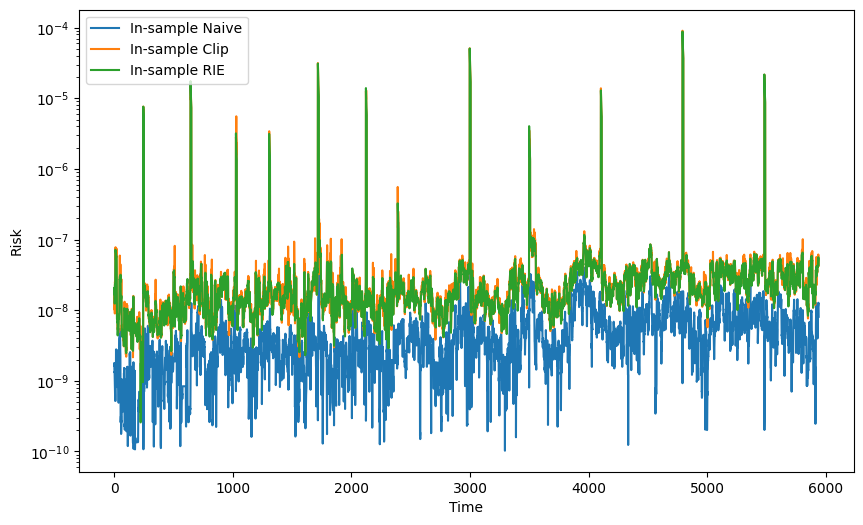

In [11]:
num_to_visualize = 10000

risks_filled_plot = risks_filled.filter(pl.col("in_sample_mvp") > 1e-10) #For better visualization

plt.figure(figsize=(10, 6))
plt.plot(risks_filled_plot["in_sample_mvp"][: min(num_to_visualize, num_rows)], label="In-sample Naive")
plt.plot(risks_filled_plot["in_sample_clip"][: min(num_to_visualize, num_rows)], label="In-sample Clip")
plt.plot(risks_filled_plot["in_sample_RIE"][: min(num_to_visualize, num_rows)], label="In-sample RIE")
plt.ylabel("Risk")
plt.xlabel("Time")
plt.legend()
plt.yscale("log")
plt.show()

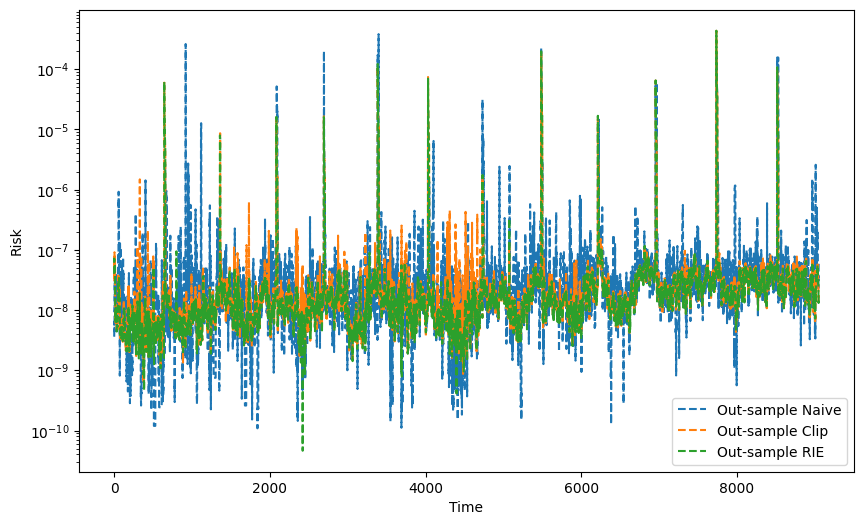

In [12]:
risks_filled_out = risks_filled.filter(pl.col("out_sample_mvp") > 1e-10)
plt.figure(figsize=(10, 6))
plt.plot(risks_filled_out["out_sample_mvp"][: min(num_to_visualize, num_rows)], label="Out-sample Naive", linestyle="--")
plt.plot(risks_filled_out["out_sample_clip"][: min(num_to_visualize, num_rows)], label="Out-sample Clip", linestyle="--")
plt.plot(risks_filled_out["out_sample_RIE"][: min(num_to_visualize, num_rows)], label="Out-sample RIE", linestyle="--")
plt.ylabel("Risk")
plt.xlabel("Time")
plt.legend()
plt.yscale("log")
plt.show()